In [1]:
import numpy as np
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable
import pandas as pd
import emcee
from matplotlib import pyplot as plt

from cluster import c, Cluster, temp_from_vdisp

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [7]:
# consts
n=0 # only collisions for now
norm = 1/4 # normalizing factor for accretion rate
mu = 1  # mean molecular weight of gas, 1 for proton gas (hydrogen)

In [8]:
# testing parameters
nrows = 100

In [9]:
# load data
# load in a dataset here
galwcls=pd.read_csv('data/galwcls.dat', sep='|', header=None, nrows=nrows)
cls_data = {'sig500': galwcls[:][8],
            'M500': galwcls[:][11],
            'r200': galwcls[:][13],
            'sig200':galwcls[:][15],
            'err_neg':galwcls[:][16],
            'err_pos':galwcls[:][17],
            'M200':galwcls[:][18]}
units = {'sig500': u.km/u.s,
            'M500': u.Msun,
            'r200': u.Mpc,
            'sig200': u.km/u.s,
            'err_neg':u.km/u.s,
            'err_pos':u.km/u.s,
            'M200': u.Msun, }
cls_table = QTable(cls_data, units=units)
# add option to select size of dataset


In [91]:
def T_b(p0, cluster):
    sigma0 = p0[0]*u.cm**2
    m_chi=p0[1]*u.GeV
    
    V=cluster.volume.to(u.cm**3)
    x = (3*const.c*c(n)*V*cluster.rho_dm*cluster.rho_b*sigma0/(cluster.m_b+m_chi)**2).to(1/u.s)
    leading_factors = (norm * 4*np.pi *const.c ** -3).to(u.s**3/u.cm**3)
    gm2 = ((const.G * cluster.bh_mass()) ** 2).to(u.cm**6/u.s**4)
    frac = ((mu * cluster.m_b) ** (5 / 2) / cluster.adiabatic_idx ** (3 / 2)).to(u.GeV**(5/2))
    nb = (2 * cluster.n_e).to(u.cm ** (-3)) # baryon number density
    D = (cluster.epsilon*leading_factors*gm2*frac*(1/nb**(2/3))**(-3/2)) # removed k_B from original function because we are working in GeV here
    return (((D*np.sqrt(cluster.m_b))/x)**(1/3)).to(u.GeV, equivalencies=u.temperature_energy())
    

In [11]:
def variance(err_neg, err_pos):
    n_temp = temp_from_vdisp(err_neg)
    p_temp = temp_from_vdisp(err_pos)
    return n_temp + p_temp

In [85]:
T_data = [temp_from_vdisp(v) for v in cls_table['sig200']]
var = variance(cls_table['err_neg'], cls_table['err_pos'])
clusters = [Cluster(cls_table['r200'][i], cls_table['M200'][i], cls_table['sig200'][i], m500=cls_table['M500'][i]) for i in range(nrows)]

In [12]:
def chi_squared(T_model, T_data, variance): # take lists of model prediction, data, and variance of same length
    chi_squared_sum = 0
    for i in range(len(T_model)):
        chi_squared_sum+=(T_model[i]-T_data[i])**2/variance[i]**2
    return chi_squared_sum

In [127]:
def log_likelihood(p0, T_data, var):
    if p0[0]<0 or p0[1]<0:
        return -np.inf
    T_model = [T_b(p0, c) for c in clusters]
    X2 = chi_squared(T_model, T_data, var)
    return (-X2/2)

In [128]:
# hyperparameters
n_burnin = 100
n_steps = 1000

In [129]:
# initialize walkers
ndim, nwalkers = 2, 5
sigma0 = np.power(10, np.random.uniform(low=-30, high=-10, size=(nwalkers, 1)))*u.cm**2
mchi = np.power(10, np.random.uniform(low=-8, high=0, size=(nwalkers, 1)))*u.GeV
p0=np.zeros((nwalkers, ndim ))
p0[:,0] = sigma0.reshape((5,))
p0[:,1]= mchi.reshape((5,))
p0

array([[5.32078384e-20, 2.43762587e-04],
       [1.41596729e-12, 1.73352715e-04],
       [3.53612100e-19, 1.41589052e-05],
       [3.72859583e-15, 5.47829421e-05],
       [3.45315220e-27, 2.49245170e-03]])

In [130]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[T_data, var])

In [131]:
state = sampler.run_mcmc(p0, n_burnin, progress=True)
sampler.reset()

You must install the tqdm library to use progress indicators with emcee


In [132]:
sampler.run_mcmc(state, n_steps, progress=True)

You must install the tqdm library to use progress indicators with emcee


State([[6.04847584e-20 2.69760396e-01]
 [2.43450646e-19 1.47051107e+00]
 [1.54585515e-19 9.80782299e-01]
 [9.04832364e-20 5.32266673e-01]
 [1.87279040e-19 1.17845202e+00]], log_prob=[-3863.65937277 -3862.93808211 -3862.94344902 -3862.95161979
 -3862.979308  ], blobs=None, random_state=('MT19937', array([4005542613,  247424337, 1177416618, 2588879209, 3355615281,
       1568391109, 2607620012, 3062205303, 1783566313, 1490455395,
       3119576709, 2990345672,  142390781, 4142128055, 2150213843,
        110975567, 3024164610,  618393847, 3250991679,  466011801,
       3515918275,  191009041, 2161914451, 1248455011, 3553444500,
       2275816284, 1758524778, 4278439725, 3178843399, 2459364966,
       1689391119, 1372500476, 2392676846, 1581623922, 2484721429,
        489359476, 3984764027,  364838859, 2208767175, 2243834479,
       3176602923,  636145465, 1659821788,   10930829,  978127610,
        354066793, 3139185231,  140123071, 4141609704, 1063224800,
       2876913507, 3376397018, 1

In [133]:
samples = sampler.get_chain(flat=True)

In [134]:
np.median(samples[:,0]), np.median(samples[:,1]) # wants to have higher value of mchi

(8.136714202785596e-20, 0.44271229791353295)

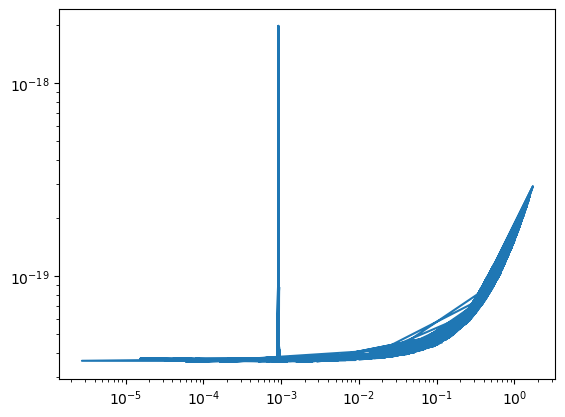

In [135]:
plt.loglog(samples[:,1], samples[:,0])

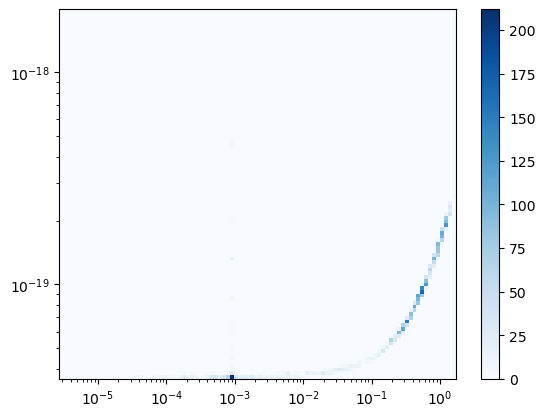

In [142]:
bins=100
xbins = np.logspace(np.log10(np.min(samples[:,1])),np.log10(np.max(samples[:,1])),bins+1)
ybins = np.logspace(np.log10(np.min(samples[:,0])),np.log10(np.max(samples[:,0])),bins+1)

plt.hist2d(samples[:,1], samples[:,0], bins=[xbins,ybins], cmap='Blues')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

In [139]:
def plot_loghist(x, bins):
    logbins = np.logspace(np.log10(np.min(x)),np.log10(np.max(x)),bins+1)
    plt.hist(x, bins=logbins)
    plt.xscale('log')
    plt.yscale('log')

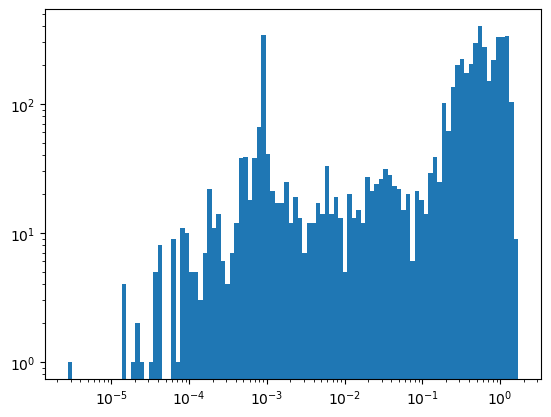

In [140]:
bins=100
plot_loghist(samples[:,1], bins=bins)


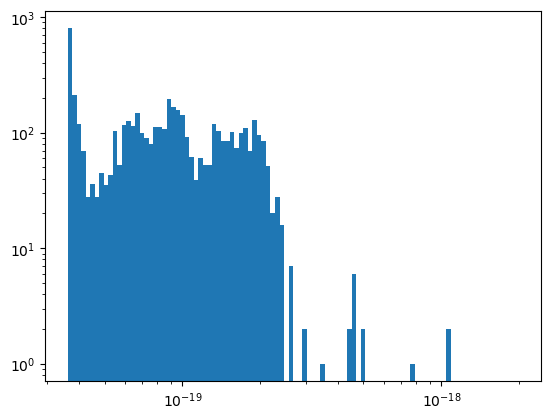

In [141]:
plot_loghist(samples[:,0], bins=bins)

In [125]:
samples[:,1]

array([-0.03247304, -0.03121125, -0.0324903 , ...,  0.68898565,
        0.4675836 ,  1.51329592])